# Data driven prediction of battery cycle life before capacity degradation

Paper:

[Severson, K.A., Attia, P.M., Jin, N. et al. Data-driven prediction of battery cycle life before capacity degradation. Nat Energy 4, 383–391 (2019)](https://www.nature.com/articles/s41560-019-0356-8)


Data:

[Experimental Data Platform (matr.io))](https://data.matr.io/1/projects/5c48dd2bc625d700019f3204)


Last edit: 10.08.2021

## Import packages and modules

In [1]:
import pathlib
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
#from sklearn.preprocessing import StandardsScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os, random
import numpy as np
import statistics

# Try with a test file

In [9]:
# edit this if you dont have the data in a subfolder called data
testfile = pathlib.Path("/Users/Andreas/Documents/Data") / "FastCharge_000007_CH39_structure.json"
testfile.is_file()

True

In [10]:
df = pd.read_json(testfile)

In [11]:
df.columns

Index(['@module', '@class', 'barcode', 'protocol', 'channel_id', 'summary',
       'cycles_interpolated', 'diagnostic_summary', 'diagnostic_interpolated',
       '@version'],
      dtype='object')

In [12]:
df.index

Index(['cycle_index', 'discharge_capacity', 'charge_capacity',
       'discharge_energy', 'charge_energy', 'dc_internal_resistance',
       'temperature_maximum', 'temperature_average', 'temperature_minimum',
       'date_time_iso', 'energy_efficiency', 'charge_throughput',
       'energy_throughput', 'charge_duration', 'time_temperature_integrated',
       'paused', 'voltage', 'current', 'temperature', 'internal_resistance',
       'step_type'],
      dtype='object')

In [6]:
df.head(20)

,@module,@class,barcode,protocol,channel_id,summary,cycles_interpolated,diagnostic_summary,diagnostic_interpolated,@version
cycle_index,beep.structure,ProcessedCyclerRun,el150800737320,2018-04-12_batch8\20180412-5_9C_15per_4_6C_new...,38,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020.10.19.20-8667111
discharge_capacity,beep.structure,ProcessedCyclerRun,el150800737320,2018-04-12_batch8\20180412-5_9C_15per_4_6C_new...,38,"[1.5537410999999999, 1.0652004, 1.0663688, 1.0...","[1.239493058590234, 1.356596500246578, 1.47369...",NaN,NaN,2020.10.19.20-8667111
charge_capacity,beep.structure,ProcessedCyclerRun,el150800737320,2018-04-12_batch8\20180412-5_9C_15per_4_6C_new...,38,"[1.063142499999999, 1.064750399999999, 1.06594...","[0.811714026408144, 0.933594370952411, 1.05547...",NaN,NaN,2020.10.19.20-8667111
discharge_energy,beep.structure,ProcessedCyclerRun,el150800737320,2018-04-12_batch8\20180412-5_9C_15per_4_6C_new...,38,"[4.7624459, 3.2459061, 3.2504842, 3.2541139, 3...",NaN,NaN,NaN,2020.10.19.20-8667111
charge_energy,beep.structure,ProcessedCyclerRun,el150800737320,2018-04-12_batch8\20180412-5_9C_15per_4_6C_new...,38,"[3.7076066, 3.6959732, 3.6983836, 3.7004894999...",NaN,NaN,NaN,2020.10.19.20-8667111
dc_internal_resistance,beep.structure,ProcessedCyclerRun,el150800737320,2018-04-12_batch8\20180412-5_9C_15per_4_6C_new...,38,"[0.015025828965008, 0.014992444775998, 0.01496...",NaN,NaN,NaN,2020.10.19.20-8667111
temperature_maximum,beep.structure,ProcessedCyclerRun,el150800737320,2018-04-12_batch8\20180412-5_9C_15per_4_6C_new...,38,"[32.24843978881836, 31.780742645263672, 31.723...",NaN,NaN,NaN,2020.10.19.20-8667111
temperature_average,beep.structure,ProcessedCyclerRun,el150800737320,2018-04-12_batch8\20180412-5_9C_15per_4_6C_new...,38,"[30.910825729370117, 31.250967025756836, 31.24...",NaN,NaN,NaN,2020.10.19.20-8667111
temperature_minimum,beep.structure,ProcessedCyclerRun,el150800737320,2018-04-12_batch8\20180412-5_9C_15per_4_6C_new...,38,"[22.150121688842773, 30.74786376953125, 30.744...",NaN,NaN,NaN,2020.10.19.20-8667111
date_time_iso,beep.structure,ProcessedCyclerRun,el150800737320,2018-04-12_batch8\20180412-5_9C_15per_4_6C_new...,38,"[2018-04-13T01:27:28+00:00, 2018-04-14T06:21:5...",NaN,NaN,NaN,2020.10.19.20-8667111


# Function to pick a number of cell files and make dataframes

- The function below takes in filepath as argument, but for the function call in the example to work, the folder structure has to be:

  Some Folder/          
          LookingAtData-Andreas.ipynb
          Beep structured files/
                                 FastCharge/
                                             FastCharge_000000_CH19_structure
                                             ...
                                             ...
                                             

In [8]:
def select_cells(number_of_cells, filepath):
    
    dataframes = []
    files = os.listdir(filepath)
    random.seed(6)
    indexes = list(random.randrange(0, len(files)-1, 1) for i in range(number_of_cells))
    print(f'random picked indexes: {indexes}')
    
    for index in indexes:
        filename= files[index]
        print(filename)
        dataframes.append(pd.read_json(os.path.join(filepath, filename)))
        
    return dataframes

In [3]:
def select_all_cells(filepath):
    dataframes = []
    files = os.listdir(filepath)
    counter = 1
    for filename in files:
        print(filename, counter)
        dataframes.append(pd.read_json(os.path.join(filepath, filename)))
        counter += 1
    return dataframe

# Function to extract a specific column from a dataframe

In [6]:
def select_dataset(df, column):
    # tested for summary column 
    
    if not isinstance(column, (list, tuple)):
        column = [column]
        
    s = df.loc[:, column]
    print(f"Shape of selected packed dataset: {s.shape}")
    
    s = s.dropna()
    print(f"Shape of selected packed dataset without NaNs: {s.shape}")
    if s.empty:
        print("Non values found")
        return
    
    s = s.T.apply(pd.Series.explode).set_index("cycle_index")
    print(f"Shape of selected unpacked dataset: {s.shape}")

    return s

# Example: Looking at data for 50 cells

In [9]:
# Creates list of dataframes containing battery data files
cells = select_cells(10, pathlib.Path("/Users/Andreas/Documents/Data"))
#cells = select_all_cells(pathlib.Path("BEEP structured data\FastCharge"))

random picked indexes: [50, 36, 52, 5, 31, 48, 16, 2, 0, 9]
FastCharge_000004_CH3_structure.json
FastCharge_000017_CH25_structure.json
FastCharge_000040_CH32_structure.json
FastCharge_000012_CH13_structure.json
FastCharge_000006_CH27_structure.json
FastCharge_000050_CH40_structure.json
FastCharge_000012_CH15_structure.json
FastCharge_000013_CH14_structure.json
FastCharge_000002_CH18_structure.json
FastCharge_000066_CH25_structure.json


In [10]:
# Ignore files with cycle life less than 150 and create list of dataframes with summary data (per cycle) and full cycling data.
df_summaries = []
df_cycles = []
for cell in cells:
    if select_dataset(cell, 'summary').index[-1] > 149:
        df_summaries.append(select_dataset(cell, 'summary'))
        
        cycle = select_dataset(cell, 'cycles_interpolated')
        #cycle = cycle.dropna()
        df_cycles.append(cycle)

Shape of selected packed dataset: (21, 1)
Shape of selected packed dataset without NaNs: (16, 1)
Shape of selected unpacked dataset: (1062, 15)
Shape of selected packed dataset: (21, 1)
Shape of selected packed dataset without NaNs: (16, 1)
Shape of selected unpacked dataset: (1062, 15)
Shape of selected packed dataset: (21, 1)
Shape of selected packed dataset without NaNs: (8, 1)
Shape of selected unpacked dataset: (2124000, 7)
Shape of selected packed dataset: (21, 1)
Shape of selected packed dataset without NaNs: (16, 1)
Shape of selected unpacked dataset: (1639, 15)
Shape of selected packed dataset: (21, 1)
Shape of selected packed dataset without NaNs: (16, 1)
Shape of selected unpacked dataset: (1639, 15)
Shape of selected packed dataset: (21, 1)
Shape of selected packed dataset without NaNs: (8, 1)
Shape of selected unpacked dataset: (3278000, 7)
Shape of selected packed dataset: (21, 1)
Shape of selected packed dataset without NaNs: (16, 1)
Shape of selected unpacked dataset: (

## Discharge capacity for the first 1000 cycles

In [23]:
# Make array of colors to scale cells according to cycle life
from matplotlib.colors import LinearSegmentedColormap
cycle_lives = np.zeros(len(df_summaries))
i = 0
for cell in df_summaries:
    cycle_lives[i] = cell.index[-1]
    i += 1
    
#cycle_lives = np.array(cycle_lives)
#cycle_lives = np.sort(cycle_lives)[::-1]
cycle_lives_norm = sorted(minmax_scale(cycle_lives), reverse=True)

colormap = mpl.cm.ScalarMappable(cmap='RdBu_r')
colors = colormap.to_rgba(cycle_lives_norm)

print(cycle_lives)
print(cycle_lives_norm)

[1061. 1638.  520. 1115. 1315.  731.  827.  788.  828. 1017.]
[1.0, 0.7110912343470484, 0.5322003577817531, 0.4838998211091235, 0.4445438282647585, 0.27549194991055453, 0.2745974955277281, 0.2397137745974955, 0.18872987477638642, 0.0]


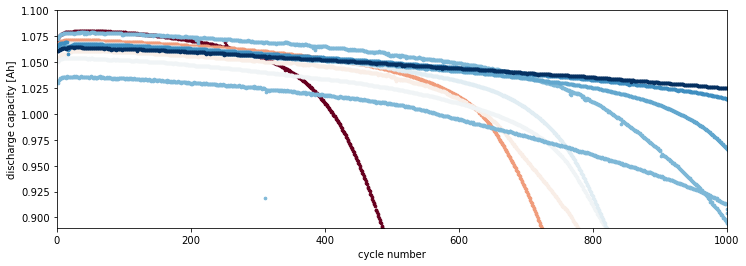

In [24]:
# Sort cells according to cycle life
sorted_summaries= sorted(df_summaries,key=lambda x:x.index[-1])

# Plot
fig, ax = plt.subplots(figsize=(12,4))
Qd_ratios = np.zeros(len(sorted_summaries))

i = 0
for cell in sorted_summaries:
    Qd = cell['discharge_capacity'][1:-1]
    cycles = cell.index[1:-1]
    
    # plot each cycle life curve
    ax.scatter(cycles, Qd, s=7, color=colors[i])
    ax.set_xlabel('cycle number')
    ax.set_ylabel('discharge capacity [Ah]')
    ax.set_xlim(0,1000)
    ax.set_ylim(0.89,1.1)
    
    #for use in histogram further down
    Qd_ratios[i] = float(cell['discharge_capacity'][99]/cell['discharge_capacity'][1])
    
    i += 1


## Detailed view of first 100 cycles

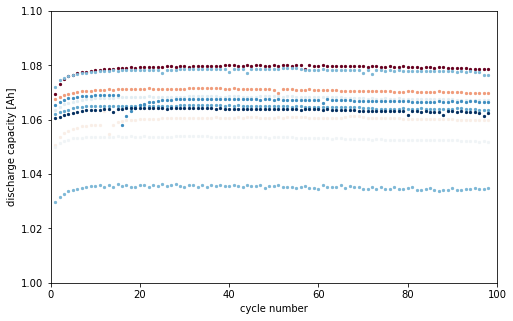

In [25]:
fig, ax = plt.subplots(figsize=(8,5))
i = 0
for cell in sorted_summaries:
    Qd100 = cell['discharge_capacity'][1:99]
    cycles = cell.index[1:99]
    ax.scatter(cycles, Qd100, s=5, color=colors[i])
    ax.set_xlabel('cycle number')
    ax.set_ylabel('discharge capacity [Ah]')
    ax.set_xlim(0,100)
    ax.set_ylim(1,1.1)
    
    i += 1

## Histogram of capacity ratios between cycle 100 and 2

Text(0, 0.5, 'Count')

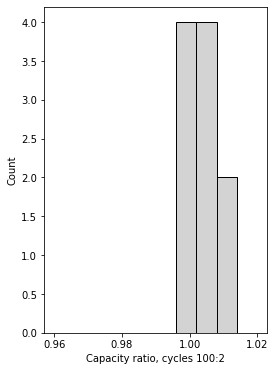

In [26]:
fig, ax = plt.subplots(figsize=(4,6))
ax.hist(Qd_ratios, range=(0.96,1.02), color='lightgrey', edgecolor='black')
ax.set_xticks([0.96, 0.98, 1.00, 1.02])
ax.set_xlabel('Capacity ratio, cycles 100:2')
ax.set_ylabel('Count', rotation=('vertical'))

## Cycle life as function of discharge capacity at cycle 2, 100 and slope of 95-100

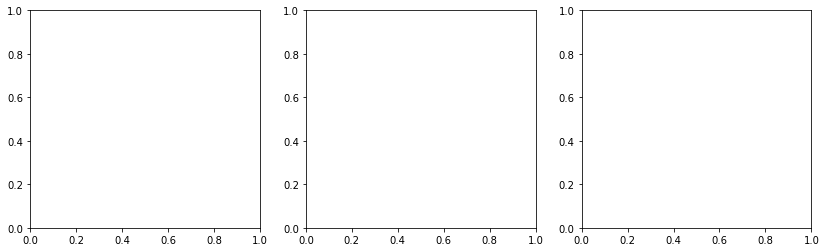

In [29]:
fig, ax = plt.subplots(ncols=3, figsize=(14,4))

Qd_cycle2 = []
Qd_cycle100 = []
Qd_cycle_95_100 = []
cycle_lives = []

for cell in df_summaries:
    cycle_lives.append(cell.index[-1])
    
    Qd_cycle2.append(float(cell['discharge_capacity'][1]))
    Qd_cycle100.append(float(cell['discharge_capacity'][99]))
    Qd_cycle_95_100.append(float(1000*(cell['discharge_capacity'][99] - cell['discharge_capacity'][94])/5))

    
# Correlation coefficients
corrcoef2 = np.corrcoef(cycle_lives, Qd_cycle2)
corrcoef100 = np.corrcoef(cycle_lives, Qd_cycle100)
corrcoef_95_100 = np.corrcoef(cycle_lives, Qd_cycle_95_100)

In [28]:
# Scatter plots
ax[0].scatter(Qd_cycle2, cycle_lives, c=cycle_lives, cmap='RdBu')
ax[0].set_xlabel('Discharge capacity at cycle 2 (Ah)')
ax[0].set_ylabel('Cycle life', rotation='vertical')
ax[0].text(0.98, 1200, f"\u03C1 =  {corrcoef2[1,0]:.2f}")

ax[1].scatter(Qd_cycle100, cycle_lives, c=cycle_lives, cmap='RdBu')
ax[1].set_xlabel('Discharge capacity at cycle 100 (Ah)')
ax[1].set_ylabel('Cycle life', rotation='vertical')
ax[1].text(0.95, 1200, f"\u03C1 =  {corrcoef100[1,0]:.2f}")

ax[2].scatter(Qd_cycle_95_100, cycle_lives, c=cycle_lives, cmap='RdBu')
ax[2].set_xlabel('Slope of discharge capacity cycles 95–100 (mAh per cycle)')
ax[2].set_ylabel('Cycle life', rotation='vertical')
ax[2].text(-0.28, 1200, f"\u03C1 =  {corrcoef_95_100[1,0]:.2f}")

plt.subplots_adjust(wspace=0.7)

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


<Figure size 432x288 with 0 Axes>

## Features based on discharge voltage curves from the first 100 cycles
### 1) Qd curves for 100th and 10th cycle for one cell
### 2) Qd difference between cycle 100 and 10 for all cells
### 3) Cycle life as function of variance of Qd_{100-10} for all cells

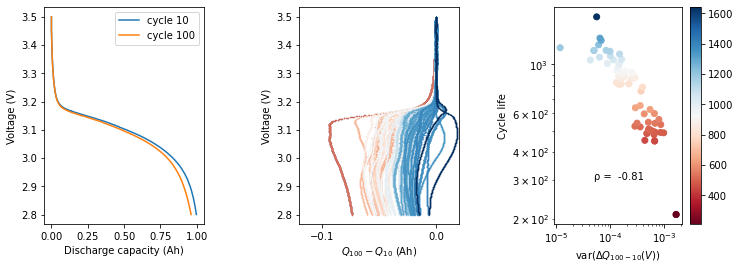

In [22]:
# One cell

# First pick a representative cell
rand_cell = df_cycles[random.randrange(len(df_cycles))]

# Discharge capacity and voltage during discharge
Qd_one = rand_cell.loc[rand_cell['step_type'] == 'discharge' , 'discharge_capacity']
voltage_one = rand_cell.loc[rand_cell['step_type'] == 'discharge' , 'voltage']

# 10th cycle
Qd10_one = Qd_one[9]
V10_one = voltage_one[9]

# 100th cycle
Qd100_one = Qd_one[99]
V100_one = voltage_one[99]

# Figure for plot
fig, ax = plt.subplots(ncols=3, figsize=(12,4))

# Plot for 100th and 10th cycle
ax[0].plot(Qd10_one, V10_one, label='cycle 10')
ax[0].plot(Qd100_one ,V100_one, label='cycle 100')
ax[0].set_xlabel('Discharge capacity (Ah)')
ax[0].set_ylabel('Voltage (V)', rotation='vertical')
ax[0].legend()

# All cells

# Sort cells by cycle life
sorted_cycles = sorted(df_cycles,key=lambda x:x.index[-1])
cycle_lives = []
Qd100_10 = []
V10 = []
var100_10 = []
counter = 0

for cell in sorted_cycles:
    cycle_lives.append(float(cell.index[-1]))
    # Qd and voltage for each cell
    Qd = cell.loc[cell['step_type'] == 'discharge' , 'discharge_capacity'] 
    voltage = cell.loc[cell['step_type'] == 'discharge' , 'voltage'] 
    
    # interpolated voltage range for a cycle (chose cycle 10, same for all)
    V10 = voltage[9]
    
    # Qd100-10 and variance
    Qd100_10 = Qd[99].values - Qd[9].values
    var100_10.append(float(statistics.variance(Qd100_10)))
    

    # Qd100-10 as function of voltage
    ax[1].scatter(Qd100_10, V10, s=0.1, color=colors[counter])
    ax[1].set_xlim(-0.12,0.02)
    ax[1].set_xticks([-0.1, 0])
    ax[1].set_xlabel('$Q_{100} - Q_{10}$ (Ah)')
    ax[1].set_ylabel('Voltage (V)', rotation='vertical')
    
    counter += 1

# Correlation coefficient
corr_variance = np.corrcoef(cycle_lives, var100_10)

# var(Qd100-10) as function of cycle life    
im = ax[2].scatter(var100_10, cycle_lives, c=cycle_lives, cmap='RdBu')
fig.colorbar(im, ax=ax[2])
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_xlabel('var($\u0394Q_{100-10}(V)$)')
ax[2].set_ylabel('Cycle life')
ax[2].text(0.00005, 300, f"\u03C1 =  {corr_variance[1,0]:.2f}")
    
plt.subplots_adjust(wspace=0.6)
    
# voltage note: Paper says voltage range 3.6 V - 2.0 V, but data shows 3.6 V - 2.8 V.

<AxesSubplot:xlabel='cycle_index'>

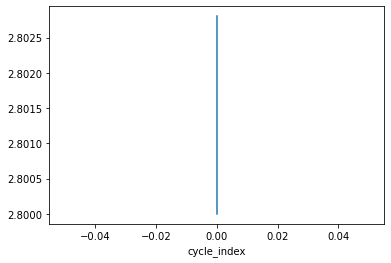

In [25]:
Qdd = df_cycles[8]['voltage'][0:5]
Qdd.plot(y='voltage')

# Modelling with var(Q100-Q10) if there is time

In [ ]:
data = pd.DataFrame()
data['Variance'] = var100_10
data['Cycle_lives'] = cycle_lives
data.plot(x='Variance', y='Cycle_lives')